In [33]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [34]:
import skimage.io
from scipy.ndimage.filters import convolve

#note: this requires the starter code for the assignments!
from common.plotting import plot_mat

In [35]:
# Fix a bug in printing SVG
if sys.platform == 'win32':
    print "Monkey-patching pydot"
    import pydot

    def force_find_graphviz(graphviz_root):
        binpath = os.path.join(graphviz_root, 'bin')
        programs = 'dot twopi neato circo fdp sfdp'
        def helper():
            for prg in programs.split():
                if os.path.exists(os.path.join(binpath, prg)):
                    yield ((prg, os.path.join(binpath, prg)))
                elif os.path.exists(os.path.join(binpath, prg+'.exe')):
                    yield ((prg, os.path.join(binpath, prg+'.exe')))
        progdict = dict(helper())
        return lambda: progdict

    pydot.find_graphviz = force_find_graphviz('c:/Program Files (x86)/Graphviz2.34/')

In [36]:
import theano
import theano.tensor.signal.downsample
import theano.tensor.nlinalg

In [37]:
from IPython.display import SVG
def svgdotprint(g):
    return SVG(theano.printing.pydotprint(g, return_image=True, format='svg'))

To get grayscale we will simply average over the last dimension (channel)

In [38]:
def max_pool(img, nr, nc):
    im_r, im_c = img.shape
    im_ret = np.zeros((np.floor(im_r/nr), np.floor(im_c/nc)))
    for r in range(im_ret.shape[0]):
        for c in range(im_ret.shape[1]):
            im_ret[r,c] = img[r*nr:(r+1)*nr, c*nc:(c+1)*nc].max()
    return im_ret

# MNIST

In [39]:
from fuel.datasets.mnist import MNIST
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

MNIST.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}))

mnist_train = MNIST(("train",), subset=slice(None,50000))
#this stream will shuffle the MNIST set and return us batches of 100 examples
mnist_train_stream = DataStream.default_stream(
    mnist_train,
    iteration_scheme=ShuffledScheme(mnist_train.num_examples, 25))
                                               
mnist_validation = MNIST(("train",), subset=slice(50000, None))

# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
mnist_validation_stream = DataStream.default_stream(
    mnist_validation, iteration_scheme=SequentialScheme(mnist_validation.num_examples, 100))
mnist_test = MNIST(("test",))
mnist_test_stream = DataStream.default_stream(
    mnist_test, iteration_scheme=SequentialScheme(mnist_test.num_examples, 100))

In [40]:
print "The streams return batches containing %s" % (mnist_train_stream.sources,)

print "Each trainin batch consits of a tuple containing:"
for element in next(mnist_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    
print "Validation/test batches consits of tuples containing:"
for element in next(mnist_test_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)

The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (25, 1, 28, 28) containing float32
 - an array of size (25, 1) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (100, 1, 28, 28) containing float32
 - an array of size (100, 1) containing uint8


In [41]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)

In [42]:
# A theano variable is an entry to the cmputational graph
# We will need to provide its value during function call
# X is batch_size x num_channels x img_rows x img_columns
X = theano.tensor.tensor4('X')

# Y is 1D, it lists the targets for all examples
Y = theano.tensor.matrix('Y', dtype='uint8')

#The tag values are useful during debugging the creation of Theano graphs

X_test_value, Y_test_value = next(mnist_train_stream.get_epoch_iterator())
#
# Unfortunately, test tags don't work with convolutions with newest Theano :(
#
theano.config.compute_test_value = 'off' # Enable the computation of test values


X.tag.test_value = X_test_value[:3]
Y.tag.test_value = Y_test_value[:3]

print "X shape: %s" % (X.tag.test_value.shape,)

# this list will hold all parameters of the network
model_parameters = []
flat_parameters  = []

#The first convolutional layer
#The shape is: num_out_filters x num_in_filters x filter_height x filter_width
num_filters_1 = 1 #1 #3 #10 #we will apply that many convolution filters in the first layer
CW1_flat = theano.shared(np.zeros((num_filters_1*1*5*5), dtype='float32'),
                   name='CW1_flat')
CW1 = CW1_flat.reshape((num_filters_1,1,5,5))
CW1_flat.tag.initializer = IsotropicGaussian(0.05)

CB1 = theano.shared(np.zeros((num_filters_1,), dtype='float32'),
                    name='CB1')
CB1.tag.initializer = Constant(0.0)
model_parameters += [CW1, CB1]
flat_parameters  += [CW1_flat, CB1]

after_C1 = theano.tensor.maximum(
    0.0,
    theano.tensor.nnet.conv2d(X, CW1) + CB1.dimshuffle('x',0,'x','x')
    )
# print "after_C1 shape: %s" % (after_C1.tag.test_value.shape,)
after_P1 = theano.tensor.signal.downsample.max_pool_2d(after_C1, (2,2), ignore_border=True) # bylo (2,2)
# print "after_P1 shape: %s" % (after_P1.tag.test_value.shape,)


num_filters_2 = 1 #3 #3 #25 #we will compute ten convolution filters in the first layer

CW2_flat = theano.shared(np.zeros((num_filters_2*num_filters_1*5*5), dtype='float32'),
                   name='CW2_flat')
CW2 = CW2_flat.reshape((num_filters_2,num_filters_1,5,5))
CW2_flat.tag.initializer = IsotropicGaussian(0.05)


CB2 = theano.shared(np.zeros((num_filters_2,), dtype='float32'),
                    name='CB2')
CB2.tag.initializer = Constant(0.0)
model_parameters += [CW2, CB2]
flat_parameters  += [CW2_flat, CB2]

after_C2 = theano.tensor.maximum(
    0.0,
    theano.tensor.nnet.conv2d(after_P1, CW2) + CB2.dimshuffle('x',0,'x','x')
    )
after_P2 = theano.tensor.signal.downsample.max_pool_2d(after_C2, (2,2), ignore_border=True) # bylo (2,2)


num_fw3_hidden= 12 #100 #was 500 !!!!!!!!!!!!!!!!!!!!!!

FW3_flat = theano.shared(np.zeros((num_filters_2*4*4*num_fw3_hidden), dtype='float32'),
                   name='FW3_flat')
FW3 = FW3_flat.reshape((num_filters_2*4*4,num_fw3_hidden))
FW3_flat.tag.initializer = IsotropicGaussian(0.05)

FB3 = theano.shared(np.zeros((num_fw3_hidden,), dtype='float32'),
                    name='FB3')
FB3.tag.initializer = Constant(0.0)
model_parameters += [FW3, FB3]
flat_parameters  += [FW3_flat, FB3]

after_F3 = theano.tensor.maximum(0.0, 
                                 theano.tensor.dot(after_P2.flatten(2), FW3) + FB3.dimshuffle('x',0))


num_fw4_hidden=10

FW4_flat = theano.shared(np.zeros((num_fw3_hidden*num_fw4_hidden), dtype='float32'),
                   name='FW4_flat')
FW4 = FW4_flat.reshape((num_fw3_hidden, num_fw4_hidden))
FW4_flat.tag.initializer = IsotropicGaussian(0.05)

FB4 = theano.shared(np.zeros((num_fw4_hidden,), dtype='float32'),
                    name='FB4')
FB4.tag.initializer = Constant(0.0)
model_parameters += [FW4, FB4]
flat_parameters  += [FW4_flat, FB4]

after_F4 = theano.tensor.dot(after_F3, FW4) + FB4.dimshuffle('x',0)

log_probs = theano.tensor.nnet.softmax(after_F4)

predictions = theano.tensor.argmax(log_probs, axis=1)

error_rate = theano.tensor.neq(predictions,Y.ravel()).mean()
nll = - theano.tensor.log(log_probs[theano.tensor.arange(Y.shape[0]), Y.ravel()]).mean()

weight_decay = 0.0
for p in flat_parameters:
    if p.name[1]=='W':
        weight_decay = weight_decay + 1e-3 * (p**2).sum()

cost = nll + weight_decay

#At this point stop computing test values
theano.config.compute_test_value = 'off' # Enable the computation of test values

X shape: (3, 1, 28, 28)


In [43]:
#
# We have built a computation graph for computing the error_rate, predictions and cost
#
#svgdotprint(nll)

In [44]:
# The updates will update our shared values
updates = []
updates2 = []

In [45]:
lrate = theano.tensor.scalar('lrate',dtype='float32')
momentum = theano.tensor.scalar('momentum',dtype='float32')
epocnt = theano.tensor.scalar('epocnt',dtype='float32')

# Theano will compute the gradients for us
gradients = theano.grad(cost, flat_parameters)

hs = theano.gradient.hessian(cost, flat_parameters)

#initialize storage for momentum
velocities = [theano.shared(np.zeros_like(p.get_value()), name='V_%s' %(p.name, )) for p in flat_parameters]

for p,g,v,h in zip(flat_parameters, gradients, velocities, hs):
    v_new = momentum * v - lrate * g
    p_new = p + v_new
    updates += [(v,v_new), (p, p_new)]

#eigvall = []    
delta1 = 1e-4
delta2 = 1e-3
    
for p,g,v,h in zip(flat_parameters, gradients, velocities, hs):
    #print v.shape, g.shape, "after_F3 shape: %s" % (p.tag.test_value.shape,)
    v_new = momentum * v - lrate * g
    eigv, eigm = theano.tensor.nlinalg.eig(h) # lub Eigh dla sym macierzy
    hinv = theano.tensor.dot(eigm.T, theano.tensor.dot(theano.tensor.nlinalg.matrix_inverse(
                (theano.tensor.nlinalg.alloc_diag(theano.tensor.abs_(eigv)))), eigm))
    dtheta = theano.tensor.dot(g, hinv)
    alpha = theano.tensor.min(delta1 / theano.tensor.dot(dtheta.T, theano.tensor.dot(h, dtheta)), delta2)
    dtheta = alpha * dtheta
    p_new = p - lrate * dtheta
    updates2 += [(v,v_new), (p, p_new)]
    
#eigvall = theano.tensor.sort(eigvall)
#eigmin = theano.tensor.min(eigvall)

In [46]:
print updates[0]
updates

(V_CW1_flat, Elemwise{sub,no_inplace}.0)


[(V_CW1_flat, Elemwise{sub,no_inplace}.0),
 (CW1_flat, Elemwise{add,no_inplace}.0),
 (V_CB1, Elemwise{sub,no_inplace}.0),
 (CB1, Elemwise{add,no_inplace}.0),
 (V_CW2_flat, Elemwise{sub,no_inplace}.0),
 (CW2_flat, Elemwise{add,no_inplace}.0),
 (V_CB2, Elemwise{sub,no_inplace}.0),
 (CB2, Elemwise{add,no_inplace}.0),
 (V_FW3_flat, Elemwise{sub,no_inplace}.0),
 (FW3_flat, Elemwise{add,no_inplace}.0),
 (V_FB3, Elemwise{sub,no_inplace}.0),
 (FB3, Elemwise{add,no_inplace}.0),
 (V_FW4_flat, Elemwise{sub,no_inplace}.0),
 (FW4_flat, Elemwise{add,no_inplace}.0),
 (V_FB4, Elemwise{sub,no_inplace}.0),
 (FB4, Elemwise{add,no_inplace}.0)]

In [47]:
#compile theano functions

#each call to train step will make one SGD step
train_step = theano.function([X,Y,lrate,momentum],[cost, error_rate, nll, weight_decay],updates=updates, on_unused_input='warn')
train_step2 = theano.function([X,Y,lrate,momentum],[cost, error_rate, nll, weight_decay],updates=updates2, on_unused_input='warn')
#each call to predict will return predictions on a batch of data
predict = theano.function([X], predictions)

In [48]:
def compute_error_rate(stream):
    errs = 0.0
    num_samples = 0.0
    for X, Y in stream.get_epoch_iterator():
        errs += (predict(X)!=Y.ravel()).sum()
        num_samples += Y.shape[0]
    return errs/num_samples


In [49]:
#utilities to save values of parameters and to load them

def init_parameters():
    rng = np.random.RandomState(1234)
    for p in flat_parameters:
        p.set_value(p.tag.initializer.generate(rng, p.get_value().shape))

def snapshot_parameters():
    return [p.get_value(borrow=False) for p in flat_parameters]

def load_parameters(snapshot):
    for p, s in zip(flat_parameters, snapshot):
        p.set_value(s, borrow=False)

In [50]:
# init training

i=0
e=0

init_parameters()
for v in velocities:
    v.set_value(np.zeros_like(v.get_value()))

best_valid_error_rate = np.inf
best_params = snapshot_parameters()
best_params_epoch = 0

train_erros = []
train_loss = []
train_nll = []
validation_errors = []

number_of_epochs = 3
patience_expansion = 1.5

In [51]:
# training loop
epocnt = 1

while e<number_of_epochs: #This loop goes over epochs
    e += 1
    #First train on all data from this batch
    epoch_start_i = i
    for X_batch, Y_batch in mnist_train_stream.get_epoch_iterator(): 
        i += 1
        
        K = 2000
        lrate = 4e-3 * K / np.maximum(K, i)
        momentum=0.9
        
        L, err_rate, nll, wdec = train_step(X_batch, Y_batch, lrate, momentum)
        
        train_loss.append((i,L))
        train_erros.append((i,err_rate))
        train_nll.append((i,nll))
        #if i % 10000 == 0:
        #    print eigen(X_batch, Y_batch)
        if i % 100 == 0:
            print "At minibatch %d, batch loss %f, batch nll %f, batch error rate %f%%" % (i, L, nll, err_rate*100)
        
    # After an epoch compute validation error
    val_error_rate = compute_error_rate(mnist_validation_stream)
    if val_error_rate < best_valid_error_rate:
        number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
        best_valid_error_rate = val_error_rate
        best_params = snapshot_parameters()
        best_params_epoch = e
    validation_errors.append((i,val_error_rate))
    print "After epoch %d: valid_err_rate: %f%% currently going to do %d epochs" %(
        e, val_error_rate*100, number_of_epochs)
    print "After epoch %d: averaged train_err_rate: %f%% averaged train nll: %f averaged train loss: %f" %(
        e, np.mean(np.asarray(train_erros)[epoch_start_i:,1])*100, 
        np.mean(np.asarray(train_nll)[epoch_start_i:,1]),
        np.mean(np.asarray(train_loss)[epoch_start_i:,1]))


At minibatch 100, batch loss 2.301771, batch nll 2.300945, batch error rate 88.000000%
At minibatch 200, batch loss 2.310752, batch nll 2.309930, batch error rate 92.000000%
At minibatch 300, batch loss 2.305181, batch nll 2.304360, batch error rate 88.000000%
At minibatch 400, batch loss 2.288456, batch nll 2.287631, batch error rate 80.000000%
At minibatch 500, batch loss 2.292042, batch nll 2.291196, batch error rate 76.000000%
At minibatch 600, batch loss 2.298955, batch nll 2.298061, batch error rate 92.000000%
At minibatch 700, batch loss 2.312648, batch nll 2.311620, batch error rate 100.000000%
At minibatch 800, batch loss 2.254777, batch nll 2.252944, batch error rate 96.000000%
At minibatch 900, batch loss 1.103641, batch nll 1.096123, batch error rate 40.000000%
At minibatch 1000, batch loss 0.871867, batch nll 0.861703, batch error rate 28.000000%
At minibatch 1100, batch loss 0.648552, batch nll 0.635762, batch error rate 24.000000%
At minibatch 1200, batch loss 1.095072, 

In [52]:
#number_of_epochs = number_of_epochs * 1.5
number_of_epochs = number_of_epochs + 3

while e<number_of_epochs: #This loop goes over epochs
    e += 1
    #First train on all data from this batch
    epoch_start_i = i
    for X_batch, Y_batch in mnist_train_stream.get_epoch_iterator(): 
        i += 1

        K = 2000
        lrate = 4e-3 * K / np.maximum(K, i)
        momentum=0.9

        L, err_rate, nll, wdec = train_step2(X_batch, Y_batch, lrate, momentum)


        train_loss.append((i,L))
        train_erros.append((i,err_rate))
        train_nll.append((i,nll))
        if i % 100 == 0:
            print "At minibatch %d, batch loss %f, batch nll %f, batch error rate %f%%" % (i, L, nll, err_rate*100)

    # After an epoch compute validation error
    val_error_rate = compute_error_rate(mnist_validation_stream)
    if val_error_rate < best_valid_error_rate:
        number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
        best_valid_error_rate = val_error_rate
        best_params = snapshot_parameters()
        best_params_epoch = e
    validation_errors.append((i,val_error_rate))
    print "After epoch %d: valid_err_rate: %f%% currently going to do %d epochs" %(
        e, val_error_rate*100, number_of_epochs)
    print "After epoch %d: averaged train_err_rate: %f%% averaged train nll: %f averaged train loss: %f" %(
        e, np.mean(np.asarray(train_erros)[epoch_start_i:,1])*100, 
        np.mean(np.asarray(train_nll)[epoch_start_i:,1]),
        np.mean(np.asarray(train_loss)[epoch_start_i:,1]))

At minibatch 416100, batch loss 0.302119, batch nll 0.270876, batch error rate 12.000000%
At minibatch 416200, batch loss 0.131105, batch nll 0.099862, batch error rate 0.000000%
At minibatch 416300, batch loss 0.226554, batch nll 0.195312, batch error rate 8.000000%
At minibatch 416400, batch loss 0.324439, batch nll 0.293197, batch error rate 4.000000%
At minibatch 416500, batch loss 0.085683, batch nll 0.054441, batch error rate 0.000000%
At minibatch 416600, batch loss 0.320017, batch nll 0.288775, batch error rate 4.000000%
At minibatch 416700, batch loss 0.175342, batch nll 0.144100, batch error rate 0.000000%
At minibatch 416800, batch loss 0.378575, batch nll 0.347333, batch error rate 8.000000%
At minibatch 416900, batch loss 0.158352, batch nll 0.127109, batch error rate 4.000000%
At minibatch 417000, batch loss 0.330239, batch nll 0.298996, batch error rate 8.000000%
At minibatch 417100, batch loss 0.272431, batch nll 0.241188, batch error rate 8.000000%
At minibatch 417200,

/home/i258328/nn_assignments/libs/Theano/theano/tensor/nlinalg.py:321: ComplexWarning: Casting complex values to real discards the imaginary part
  w[0], v[0] = [z.astype(x.dtype) for z in self._numop(x)]


KeyboardInterrupt: 

Setting network parameters from after epoch 138
Test error rate is 8.710000%


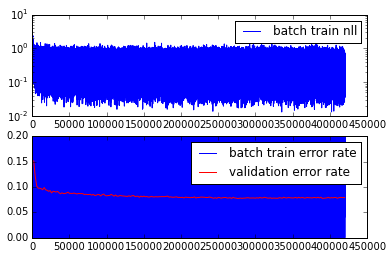

In [53]:
print "Setting network parameters from after epoch %d" %(best_params_epoch)
load_parameters(best_params)

print "Test error rate is %f%%" %(compute_error_rate(mnist_test_stream)*100.0,)

subplot(2,1,1)
train_nll_a = np.array(train_nll)
semilogy(train_nll_a[:,0], train_nll_a[:,1], label='batch train nll')
legend()

subplot(2,1,2)
train_erros_a = np.array(train_erros)
plot(train_erros_a[:,0], train_erros_a[:,1], label='batch train error rate')
validation_errors_a = np.array(validation_errors)
plot(validation_errors_a[:,0], validation_errors_a[:,1], label='validation error rate', color='r')
ylim(0,0.2)
legend()